In [1]:
source('source.r')

load('RStates/ship.final.rdata')
load('RStates/mld-0.1.rdata')

Packages Loaded:
ncdf4 R.matlab openxlsx RColorBrewer compiler lattice geosphere readxl data.table rworldmap rworldxtra


Loading required package: ncdf4
Loading required package: R.matlab
R.matlab v3.6.1 (2016-10-19) successfully loaded. See ?R.matlab for help.

Attaching package: 'R.matlab'

The following objects are masked from 'package:base':

    getOption, isOpen

Loading required package: openxlsx
Loading required package: RColorBrewer
Loading required package: compiler
Loading required package: lattice
Loading required package: geosphere
Error: package or namespace load failed for 'geosphere' in loadNamespace(i, c(lib.loc, .libPaths()), versionCheck = vI[[i]]):
 there is no package called 'sp'
Loading required package: readxl
Loading required package: data.table
Loading required package: rworldmap
Warning message:
"package 'rworldmap' was built under R version 3.4.3"Loading required package: rworldxtra
Warning message:
"package 'rworldxtra' was built under R version 3.4.3"

In [2]:
ctd = read.xlsx('Raw Data/CTD/DataZoo - P1706 CTD Downcast Data.xlsx')
ctd$Time = conv_excel_time(ctd$DateTime_GMT, tz = 'UTC')

ctd.log = read.xlsx('Raw Data/CTD/DataZoo - P1706 CTD Cast Log.xlsx', sheet='Data')

#ship.log = read.xlsx('Raw Data/CCEP1706 Event Log.xlsx')

str(ctd)
str(ctd.log)
#str(ship.log)

'data.frame':	41780 obs. of  35 variables:
 $ Cruise      : chr  "CCE-P1706" "CCE-P1706" "CCE-P1706" "CCE-P1706" ...
 $ Cycle       : chr  "Cycle0" "Cycle0" "Cycle0" "Cycle0" ...
 $ EventNo     : num  3 3 3 3 3 3 3 3 3 3 ...
 $ Cast        : num  1 1 1 1 1 1 1 1 1 1 ...
 $ DateTime_GMT: num  42888 42888 42888 42888 42888 ...
 $ Direction   : chr  "down" "down" "down" "down" ...
 $ Pressure    : num  2 3 4 5 6 7 8 9 10 11 ...
 $ Depth       : num  1.99 2.98 3.97 4.96 5.96 ...
 $ T090C       : num  16.9 16.8 16.9 16.9 16.8 ...
 $ T190C       : num  16.8 16.8 16.9 16.9 16.8 ...
 $ Cond1       : num  4.3 4.29 4.3 4.3 4.29 ...
 $ Cond2       : num  4.29 4.29 4.3 4.3 4.3 ...
 $ Sal00       : num  33.4 33.4 33.4 33.4 33.4 ...
 $ Sal11       : num  33.4 33.4 33.4 33.4 33.4 ...
 $ OxymicroM   : num  195 196 195 195 195 ...
 $ OxyPerSat   : num  81 81.1 81 80.9 80.8 ...
 $ SurPAR      : num  8632 8632 8632 8632 8632 ...
 $ PAR         : num  1292 1053 887 775 688 ...
 $ Cpar        : num  0.1496

## Plot some summary profiles

In [3]:
plot.cycle = function(cycle = 'Cycle0') {
    l = which(ctd$Cycle == cycle)
    plot(ctd$Sal00[l], ctd$Depth[l], pch=20, cex=0.8, col='#00000090', ylim=c(100,0), ylab='Depth',
         xaxs='i', yaxs='i', main=cycle, xlab='Fluor', xlim = c(32.8,34.1))
}
unique(ctd$Cycle)

[1] "Cycle0"    "Transect1" "Cycle1"    "Cycle2"    "Transect2" "Cycle3"   
 [7] "Transect3" "Cycle4"    "BBL"       "TransComp"

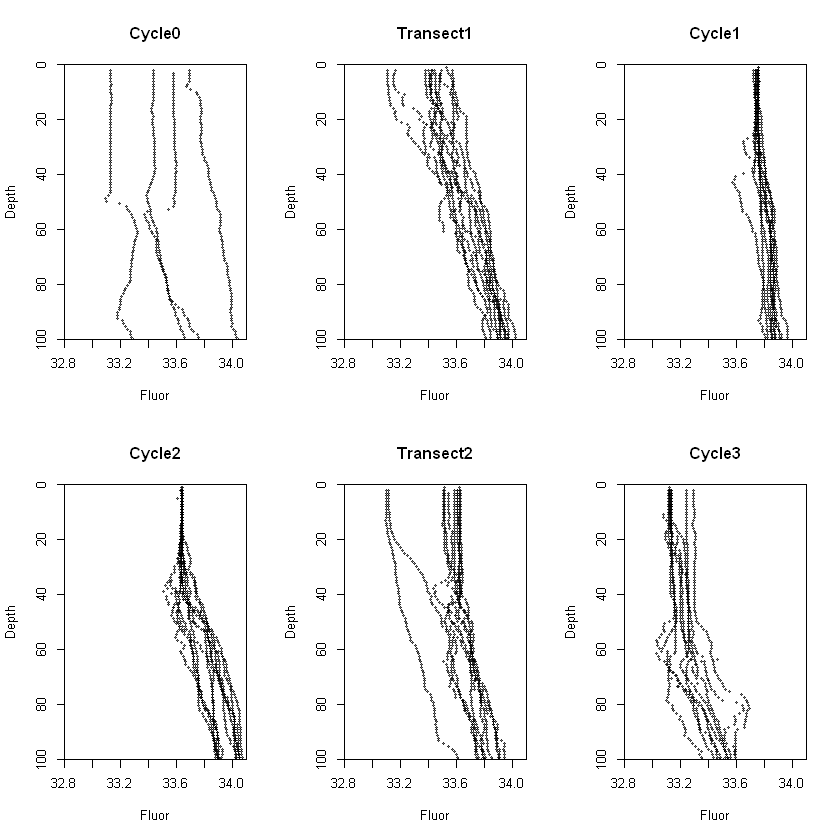

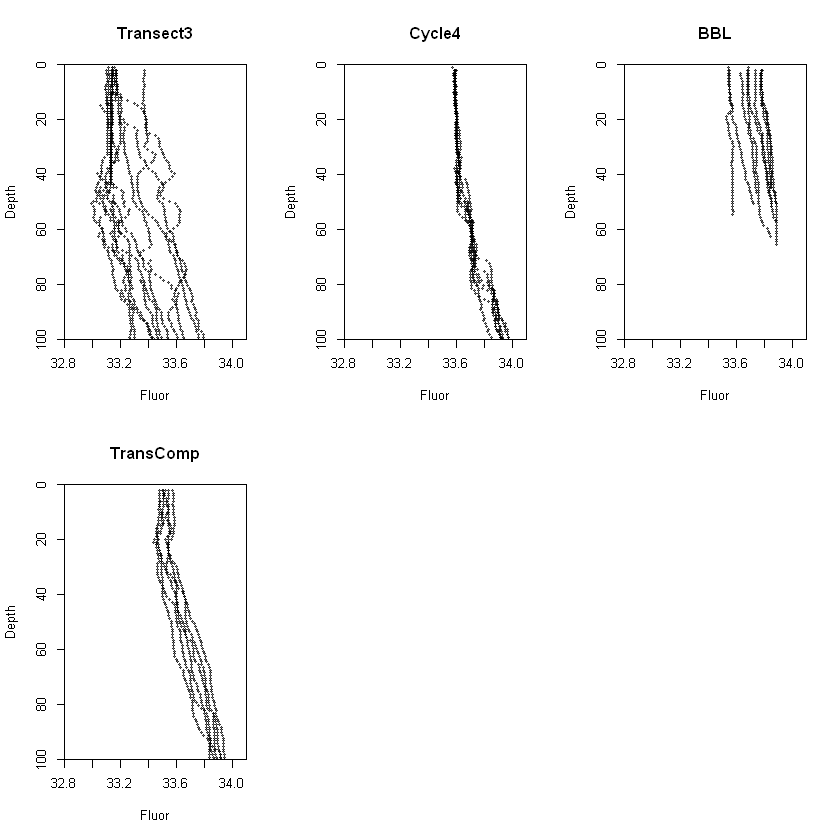

In [65]:
#pdf('Output/CTD/CTD Module - Summary of Sal Profiles per Cycle.pdf')
#png('Output/CTD/CTD Module - Summary of Sal Profiles per Cycle.png')

par(mfrow=c(2,3))
for (i in unique(ctd$Cycle)) {
    plot.cycle(i)
}

#dev.off()

In [18]:
get.cast = function(cast, dir = 'down') {
    l = which(ctd$Cast == cast & ctd$Direction == dir)
    ctd[l,]
}

get.avg.temp = function(cast, mld) {
    l = which(ctd$Cast == cast & ctd$Direction == 'down')
    trap.integrate(ctd$Depth[l], ctd$T090C[l], mld)
}

get.avg.S = function(cast, mld) {
    l = which(ctd$Cast == cast & ctd$Direction == 'down')
    trap.integrate(ctd$Depth[l], ctd$Sal00[l], mld)
}


calc.cycle.avg = function(time = '2 am') {
    data = data.frame(Cycle = '', Cast = '', T = 0, S = 0, stringsAsFactors = FALSE)
    
    casts.times = which(ctd.log$Station.Type == time)

    for (i in unique(ctd.log$Cycle)) {
        l = which(ctd.log$Cycle == i)
        k = intersect(casts.times, l)  ## Which entries do we care about (cycle + 2am)

        if (length(k) > 0) {
            casts = ctd.log$Cast[k] ## Which casts

            for (j in casts) {  ## for each cast
                cast.mld = mld$mld[which(mld$Cast == j)]
                data = rbind(data, c(i, j, get.avg.temp(j, cast.mld), get.avg.S(j, cast.mld)))
            }   
        }
    }
    data = data[-1,]
    data
}

get.flow.T = function(data, flow.time, flow, t.window = 12, d = Inf) {
    m = c()
    s = c()
    n = c()
    for (i in 1:nrow(data)) {
        cast.time = conv_excel_time(ctd.log$DateTime_GMT[which(data$Cast[i] == ctd.log$Cast)])
        dt = as.numeric(difftime(cast.time, flow.time, units = 'hours'))
        l = which(dt^2 < t.window^2)
        ld = which(data$Dist.to.Drifter[l] < d)
        
        m = c(m, mean(flow[l[ld]], na.rm = TRUE))
        s = c(s, sd(flow[l[ld]], na.rm = TRUE))
        n = c(n, length(ld))
    }
    if (any(n == 0)) {
        warn('Some temperature sets contained 0 elements.')
    }
    list(m = m, s = s, n = n)
}

In [35]:
str(ctd.log)
temp = calc.cycle.avg()
inlet = get.flow.T(temp, ship.data$DT, ship.data$Inlet.T)
ship = get.flow.T(temp, ship.data$DT, ship.data$TT)
mims = get.flow.T(temp, ship.data$DT[ship.data$Optode.temp2.FLAG == 1],
                  ship.data$Optode.temp2[ship.data$Optode.temp2.FLAG == 1])

temp$Inlet.m = inlet$m
temp$Inlet.s = inlet$s
temp$MIMS.m = mims$m
temp$MIMS.s = mims$s
temp$ship.m = ship$m
temp$ship.s = ship$s

temp

'data.frame':	90 obs. of  10 variables:
 $ Cruise      : chr  "CCE-P1706" "CCE-P1706" "CCE-P1706" "CCE-P1706" ...
 $ Cycle       : chr  "Cycle0" "Cycle0" "Cycle0" "Transect1" ...
 $ EventNo     : num  3 14 127 130 136 141 146 154 161 168 ...
 $ Cast        : num  1 2 3 4 5 6 7 8 9 10 ...
 $ Station.Type: chr  "test" "test" "experimental" "transect" ...
 $ DateTime_GMT: num  42888 42889 42893 42894 42894 ...
 $ Lat         : num  33.1 34.3 33.9 34.9 34.9 ...
 $ Long        : num  -118 -120 -122 -121 -121 ...
 $ Notes       : chr  "SPAR off" "Santa Barbara Basin (Nuts are off at depth). no PAR sensor SPAR off" "no PAR sensor" NA ...
 $ Actions     : chr  "deleted SPAR values" "deleted SPAR values" NA NA ...


,Cycle,Cast,T,S,Inlet.m,Inlet.s,MIMS.m,MIMS.s,ship.m,ship.s
2,Cycle1,15,12.5038264373117,33.7545865158583,12.37897,0.03012449,14.16545,1.2108156,13.40488,0.46529489
3,Cycle1,22,12.9782991309515,33.744021495679,12.65861,0.15387474,13.42192,0.1241320,13.21773,0.12634183
4,Cycle1,24,12.526264802464,33.7259638319504,13.86964,0.44734157,13.73658,1.1084143,13.19834,0.56754811
5,Cycle2,25,12.9063678842944,33.6415778712034,13.08513,0.94415316,13.56394,0.6050423,13.70488,0.93135821
6,Cycle2,29,12.7050323110465,33.6344850579869,12.45821,0.05231785,13.36943,0.5595647,13.11987,0.07265957
7,Cycle2,31,12.801530176045,33.6410344454427,12.47024,0.03878158,13.60810,1.1041012,13.20116,0.06618789
8,Cycle2,33,12.8278669929425,33.6235585159267,12.63805,0.07904420,13.54322,0.3071371,13.30940,0.08777159
9,Cycle2,36,13.0147997490064,33.631906327745,13.08560,0.22763494,13.95546,0.4514564,13.52947,0.19636233
10,Cycle3,48,13.6102196003563,33.2941101693472,14.49243,0.84948315,15.37880,0.8954355,15.00367,0.84516178
11,Cycle3,52,15.1426305386183,33.1269746049012,14.78532,0.59403188,15.69686,0.5900612,15.27725,0.62953636


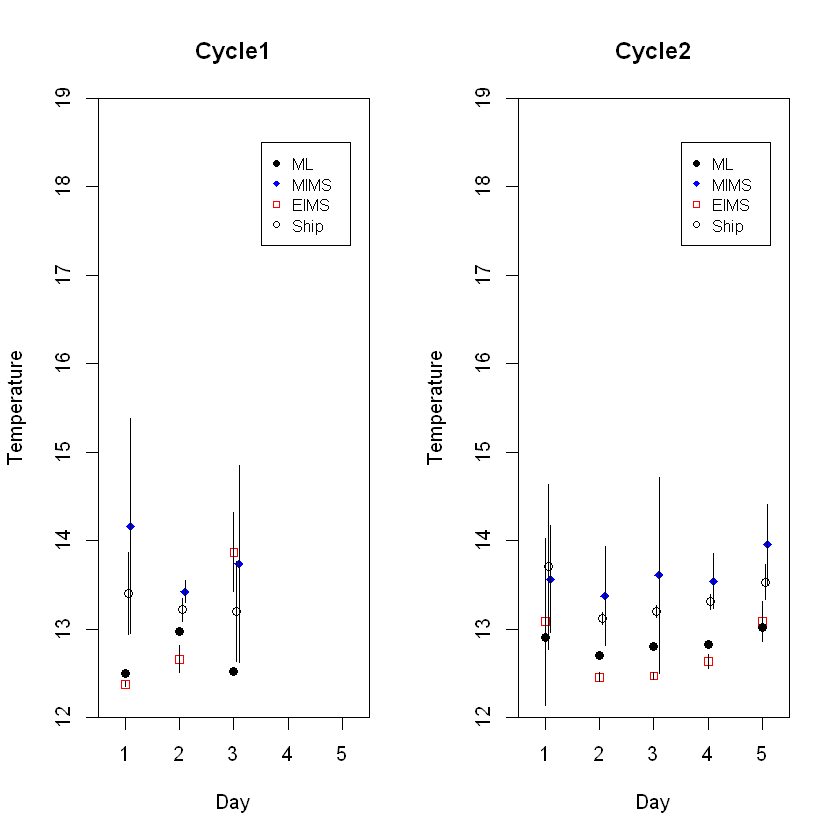

null device 
          1

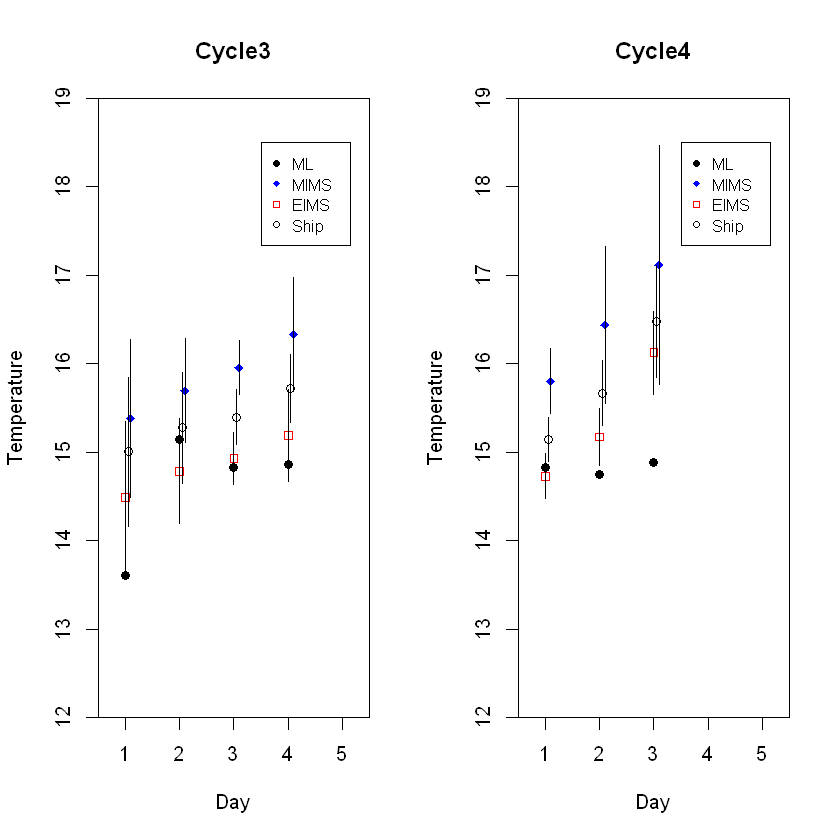

In [49]:
#pdf('Output/CTD Module - T per day summary.pdf')
#png('Output/CTD Module - T per day summary.png')

par(mfrow=c(1,2))
for (i in unique(temp$Cycle)) {
    l = which(temp$Cycle == i)
    plot(NULL, NULL, ylim=c(12,19), xlim=c(0.5, 5.5), xaxs='i', yaxs='i', ylab='Temperature', xlab='Day', main=i)
    
    for (j in 1:length(l)) {
        points(j, temp$Inlet.m[l[j]], col='red', pch=22)
        add.error.bars(j, 0, temp$Inlet.m[l[j]], temp$Inlet.s[l[j]])
        
        points(j+0.1, temp$MIMS.m[l[j]], col = 'blue', pch=18)
        add.error.bars(j+0.1, 0, temp$MIMS.m[l[j]], temp$MIMS.s[l[j]])
        
        points(j+0.05, temp$ship.m[l[j]], col = 'black', pch=1)
        add.error.bars(j+0.05, 0, temp$ship.m[l[j]], temp$ship.s[l[j]])
        
        points(j, temp$T[l[j]], pch=16)
    }
    legend(3.5, 18.5, c('ML', 'MIMS', 'EIMS', 'Ship'), col=c('black', 'blue', 'red', 'black'),
           pch=c(16, 18, 22, 1), cex=0.8)
}

dev.off()

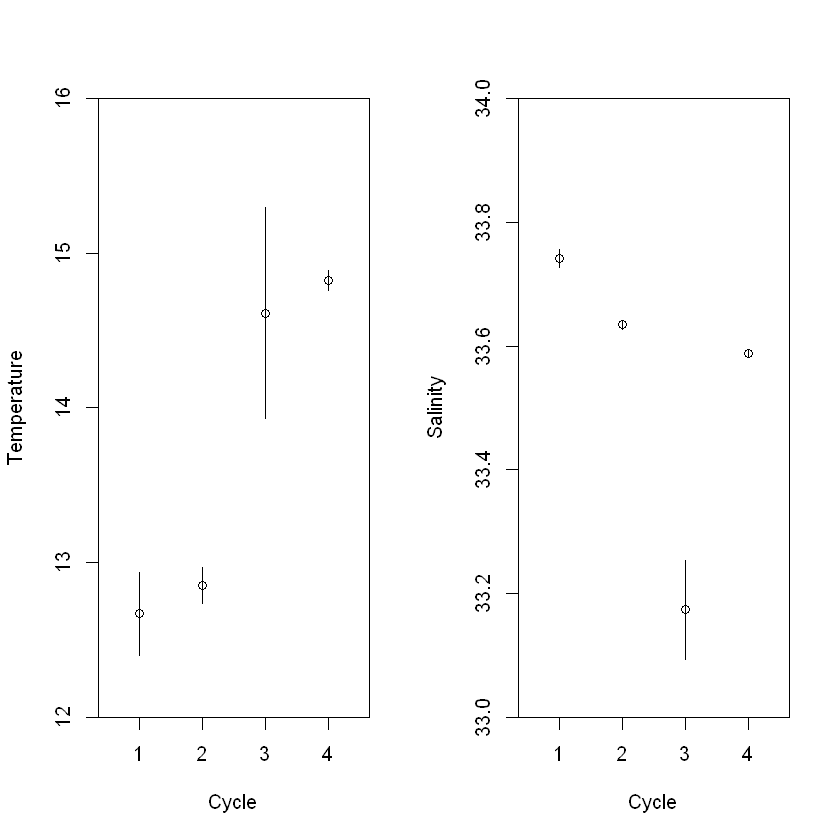

In [6]:
#pdf('Output/CTD Module - T and S cycle summary.pdf')
#png('Output/CTD Module - T and S cycle summary.png')

T.m = c()
T.s = c()
S.m = c()
S.s = c()

for (i in unique(temp$Cycle)) {
    l = which(temp$Cycle == i)
    
    T.m = c(T.m, mean(as.numeric(temp$T[l])))
    T.s = c(T.s, sd(temp$T[l]))
    S.m = c(S.m, mean(as.numeric(temp$S[l])))
    S.s = c(S.s, sd(temp$S[l]))
}
par(mfrow=c(1,2))

## Temperature
plot(NULL, NULL, xlim = c(0.5, 4.5), ylim = c(12, 16), ylab='Temperature', xlab='Cycle', yaxs='i')
points(c(1:4), T.m)
add.error.bars(c(1:4), rep(0,4), T.m, T.s)

## Salinity
plot(NULL, NULL, xlim = c(0.5, 4.5), ylim = c(33, 34), ylab='Salinity', xlab='Cycle', yaxs='i')
points(c(1:4), S.m)
add.error.bars(c(1:4), rep(0,4), S.m, S.s)

#dev.off()